In [1]:
""" Introduction to Machine Learning in Chemistry (Part II)"""

__author__ = "Idil Ismail"
__date__ = "02-08-2022"

<div class="alert alert-danger" role="alert">


# Computational Toolkit Seminar Series:
# Introduction to Machine Learning in Chemistry (Part II)
    
This notebook serves as a tutorial for machine learning in chemistry.
    
[Click here for the full video on the Computational Toolkit YouTube channel](https://www.youtube.com/channel/UCOYC86wK1r69OHmMLVmzXlQ)
    
    
[>>Our webpage](https://computationaltoolkit.github.io/)

In [2]:
!pip install yellowbrick rdkit-pypi PyTDC lightgbm

In [3]:
# Generic imports
import numpy as np # numerical python
import matplotlib.pyplot as plt # plotting and visualisation
import pandas as pd #  data manipulation and analysis.
import csv # delimited text file for storing data (think microsoft excel!)

# Chemical Descriptors (RDkit) imports
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import AllChem, DataStructs

# Machine Learning (sci-kit learn) imports
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

# Introduction

**Why do we use machine learning in chemistry?**

Although it is possible to predict a wide range of chemical properties using ab-initio electronic structure calculations with high accuracy, these calculations are typically very computationally intensive, which limits their use. By contrast, machine learning can provide us with an inexpensive substitute for making these predictions.

Over the past decade machine learning has been increasingly used in all areas of the chemical industry, from materials modeling to drug design.This tutorial attempts to explain the fundamental concepts and uses of machine learning in chemistry for an undergraduate audience, using freely available software tools.

## First we'll begin with a quick recap of the core principles of machine learning. 

Lets start off with importing a few of packages. Here we'll be using [scikit-learn](https://scikit-learn.org/stable/) as our machine learning software package of choice. For our descriptors, we'll use two-dimensional feature vectors, using the [RDKit](https://www.rdkit.org/) chemoinformatics package.
Check out the link and search for the installation instructions if you don't already have access to them on your computer.

### Linear regression

In **supervised machine learning**, linear regression is the model that finds the best fit between two given variables of interest. In the last seminar we gave a generic example of *'soil nutrient concentration vs crop yield'*. Regression in general involves building a model that attempts to predict a continuous quantity, whereby we map a function (f) from input variables (X) onto a continuous output variable (y).

- When we use **supervised learning**, we tell the ML algorithm what the labels are. However, when we use **unsupervised learning**, we donot inform the algorithm what our labels are. It's important to remember this distinction.

![Types of ML](./MLsummary.png)


***Simple regression***
$y = b_0 + b_1x$,

where $b_0$ is the intercept, $b_1$ is coefficient or slope, $x$ is the independent variable and $y$ is the dependent variable.

![regression](./regression_figure.png)

Image Source: Statistical tools for high-throughput data analysis

Now, to get a better regression estimate, you will need to adjust the gradient ($b_1$). In essense, we need to reduce the loss function. This is done iteratively using the process of *gradient descent*.

**Loss function:**  a method of evaluating how well your machine learning algorithm models your featured data set. In other words, loss functions are a measurement of how good your model is in terms of predicting the expected outcome. Our goal is to minimize loss.

There are several types of loss functions. Here we'll focus on regression-type loss functions, namely the ***mean absolute error***.

**Mean Absolute Error (MAE):** is the average of absolute differences between the actual and the predicted value. It’s the second most commonly used regression loss function. It measures the average magnitude of errors in a set of predictions, without considering their directions.



MAE = $\frac{\Sigma_{i=1}^n |y_{pred,i} - y_i}n$


To reduce the "loss function" we use gradient descent. The gradient descent algorithm takes a step in the direction of the negative gradient in order to reduce loss as quickly as possible, but more on that in our previous seminar video on gradient descent.

**Gradient Descent**

[YouTube: 12 minute introduction to gradient descent](https://www.youtube.com/watch?v=X5NCFy1L0dk&ab_channel=TheComputationalToolkit)

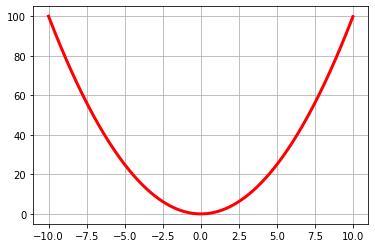

In [4]:
# Plotting Curve
x = np.arange(-10, 10, 0.01)
y = np.square(x)

plt.plot(x, y, "red",linewidth=3.0)
plt.grid(True, which="major")
plt.show()

<div class="alert alert-block alert-info">
    
## Step 1: Import Data
    

**Definition:** Machine learning is when we teach computers patterns in data such that they can recognise those patterns and apply them to new things that they haven’t seen before.

So, the first thing we will need is a large enough **dataset**.

Machine learning follows a **garbage in garbage out** methodology, so it's important that you understand and carefully select the data you want to train your model on.

A few things to remember before training your model.
> 1. Perform some basic exploratory analysis on your dataset. Make sure the dataset you're working with is consistent and that the chemical properties were generated using high accuracy methods. You could even look at the similarity between the data you intend to deploy your model on vs the training data using things like [Tanimoto](https://www.rdkit.org/docs/GettingStartedInPython.html)/ Fraggle similarity score.
> 2. To ensure generalisability, avoid data leackage. Make sure you keep your test and training data completley separate. Avoid mixing at all costs. For molecular prediction tasks, this can be best achieved using [Bemis−Murcko scaffolding](https://pubmed.ncbi.nlm.nih.gov/8709122/) technique.
> 3. Make sure you have enough data. The size of the dataset needed depends entirely on the signal to noise ratio of your data. More signal means you can get away with using a smaller dataset. However if you don't have a lot of data, its important that you limit the complexity of your chosen model.


**Dataset:** https://moleculenet.org/datasets-1

-  Experimental results of octanol/water distribution coefficient (logD at pH 7.4).

The n-octanol-water partition coefficient, (Kow) is a partition coefficient for the two-phase system consisting of n-octanol and water.[[1]](https://www.worldcat.org/title/octanol-water-partition-coefficients-fundamentals-and-physical-chemistry/oclc/36430034) 

Kow serves as a measure of the relationship between lipophilicity (fat solubility) and hydrophilicity (water solubility) of a substance. The value is greater than one if a substance is more soluble in fat-like solvents such as n-octanol, and less than one if it is more soluble in water.


**Task:** Predict the octanol/water distribution coefficient using a neural network.
    
</div>


In [5]:
def ReadDataset(file):
    """
    Reads the CSV dataset in file. 
    The dataset should contain the SMILES strings , the experimental distribution coeficient.
    """
    data = pd.read_csv(file)
    df = pd.DataFrame(data)
    display(df)
    
    chem_id = data.CMPD_CHEMBLID.tolist()                 
    exp_value = data.exp.tolist()                 
    chem_smiles = data.smiles.tolist()              

    return chem_id,exp_value,chem_smiles

In [6]:
n = 4200 # Number of data points in the dataset you would like to use
chem_id,exp_value,chem_smiles = ReadDataset('Lipophilicity.csv')
ExperimentalCo = [] # List of experimental distribution coeficient
for i in range(n):
    ExperimentalCo.append(exp_value[i])

AveExp = np.mean(ExperimentalCo) # average 
Exp_range = np.std(ExperimentalCo) # range
print('range: ',Exp_range,' | avg: ',AveExp)

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


range:  1.2028604901336188  | avg:  2.1863357142857143


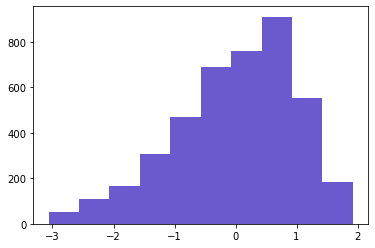

In [7]:
import matplotlib.pyplot as plt

def Normalize(x,xmean,xrange,ntype):
    """
    Returns the mean-normalized value. x = (x-xave) / (xmax-xmin)    
    """
    if ntype == 'Zscore':
        return (x - xmean) / xrange
    elif ntype == 'none':
        return x
    elif ntype == 'shift':
        return x - xmean
    
def unNormalize(x,xmean,xrange,ntype):
    """
    Undoes the normalization of x: x = x * xrange + xmean
    """
    if ntype == 'Zscore':
        return x * xrange + xmean
    elif ntype == 'none':
        return x
    elif ntype == 'shift':
        return x + xmean

ExperimentalCo = Normalize(ExperimentalCo, AveExp,Exp_range ,'Zscore')
plt.hist(ExperimentalCo[0:int(n)],bins=10,color='slateblue');

<div class="alert alert-block alert-info">
    
## Step 2: Calculate Descriptor Vector

1. Convert smiles to rdkit mol object
2. Calculate Morgan Fingerprint vector
    
Our data, in this case, chemical structures, needs to be translated into a machine readable format in order to be able to train our model. For many years we've been using simple graphs to represent chemical structures, where atoms are seen "nodes" and bonds as "edges". Using simple 2D and 3D representations of our molecules, we can capture additional, chemically relevant information to be interpreted by our machine learning model.

Regardless of whether you choose to use a 2D or 3D vector representation of your molecule, the following image lists some basic requirements for optimal descriptors.

![descriptor](./descriptors.png)

*Cite*:https://en.wikipedia.org/wiki/Molecular_descriptor

For 3D descriptors you'll need to consider some additional invariance properties, namely;

- Translational invariance
- Rotational invariance
- Permutational invariance

A translated or rotated struture should be interpreted in the same way.
    
    
**Here we will focus on using 2D descriptors!**
    
</div>

### A quick example before we load our own dataset

You can use rdkit to visualise the smiles strings as their actual molecular structures.

In [8]:
!pip install rdkit-pypi mols2grid
!wget https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.test.sdf
import mols2grid
from pathlib import Path
from rdkit import RDConfig
SDF_PATH = (f"{RDConfig.RDDocsDir}/Book/data/solubility.test.sdf"
            if Path(RDConfig.RDDocsDir).is_dir() else "solubility.test.sdf")
mols2grid.display(SDF_PATH,
                  # RDKit's MolDrawOptions parameters
                  fixedBondLength=25,
                  # rename fields for the output document
                  mapping={"SOL": "Solubility",
                           "SOL_classification": "Class",
                           "NAME": "Name"},
                  # set what's displayed on the grid
                  subset=["ID", "img", "Solubility"],
                  # set what's displayed on the tooltips
                  tooltip=["Name", "SMILES", "Class", "Solubility"],
                  # style for the grid labels and tooltips
                  style={"Solubility": lambda x: "color: red" if x < -3 else "color: black"},
                  # change the precision and format (or other transformations)
                  transform={"Solubility": lambda x: round(x, 2)})

# retrieve the index and SMILES of your selection
mols2grid.selection

smiles = ["CCO", "c1ccccc1", "N", "CO", "O=S(=O)(-O)(-O)", "CCC", "CCC=O"]
df = pd.DataFrame({"smi": smiles,
                   "id": range(1, len(smiles) + 1)})
# setup the grid
mg = mols2grid.MolGrid(df, smiles_col="smi", size=(110, 90))
mg.display(subset=["id", "img"], n_cols=7)

--2023-06-29 17:54:21--  https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.test.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245735 (240K) [text/plain]
Saving to: ‘solubility.test.sdf.5’

solubility.test.sdf 100%[===================>] 239.98K  --.-KB/s    in 0.05s   

2023-06-29 17:54:22 (4.65 MB/s) - ‘solubility.test.sdf.5’ saved [245735/245735]



/home/u1860474/anaconda3/lib/python3.8/site-packages/mols2grid/molgrid.py:118: UserWarning: `mapping` is deprecated and will be removed soon. Consider using `rename` in the future.
  warnings.warn(


In [9]:
'''
Now we need to create rdkit mol objects from the smiles strings we read in from the dataset.
'''
chem_mol = []
for i in range(int(n)):
    chem_mol.append(Chem.MolFromSmiles(chem_smiles[i]))

![Geometric representation](./graph.png)


**Loosley speaking, what are Morgan Fingerprints?** 

Morgan fingerprints are a fingerprint representation of a molecule, where it looks at different substructures in the molecule, and if some given substructure is present in the molecule, it will index it as a $one$ in the vector array, and $zero$ if not present. And so it creates a bit vector representation, something computers are very attuned to dealing with.

In [10]:
nreact = len(chem_mol)
print("nreact: ",nreact)
nb = 1024

nadditional = 1
diff = np.zeros([nreact,nb+nadditional])
for i in range(nreact):

    # Calculate Morgan Fingerprint counts.
    fp1 = AllChem.GetHashedMorganFingerprint(chem_mol[i],5,nBits=nb)

    # Convert fingerprint count arrays to numpy arrays.
    array1 = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp1, array1)
    
    for j in range(nb):
        diff[i,j] =  array1[j]

diff

nreact:  4200


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<div class="alert alert-block alert-info">
    
## Step 3: Split Data
    
- K-fold cross validation
    
Even better would be - the Bemis-Murcko split.
Scaffold splits are a better measure of generalizability compared to random splits like K-fold. However, here, we're going to keep it simple and stick with k-fold cross validation.
- [Generate Murcko-Scaffold](https://rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html)

    
</div>

![cross validation](./slide.png)


In [11]:
X = diff
y = np.array(ExperimentalCo)
random_state = 1000
kf = RepeatedKFold(n_splits=5,n_repeats=1,random_state = random_state)

cc = 1
for train_index, test_index in kf.split(X):

    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    cc += 1

<div class="alert alert-block alert-info">
    
## Step 4: Train Machine Learning Model - (Neural Network)


    
</div>

In [12]:
from sklearn import preprocessing
nr=5 # number of ensembles (you want to take an average of the neural network)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

regr = []
for i in range(nr):
    regr.append(MLPRegressor( hidden_layer_sizes=(900),
                activation='relu', max_iter=1000,shuffle=True).fit(X_train, y_train))

<div class="alert alert-block alert-info">
    
## Step 5: Test Machine Learning Model

1. Error estimation: MAE \& RMSE \& R$^2$
2. Correlation plot
    
</div>

In [13]:
#preprocessing
from sklearn import preprocessing
ntype='Zscore'
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##load trained regressor

##Predicting
ntest = len(y_test)
ntrain = len(y_train)

Exp_predict = np.zeros(ntest)
for i in range(nr):
    pred = regr[i].predict(X_test)
    pred = unNormalize(pred,AveExp, Exp_range,ntype)
    Exp_predict += pred
    R2=regr[i].score(X_test, y_test)
    print("\n* ANN R2 = ",i,regr[i].score(X_test, y_test),"\n")
Exp_predict = Exp_predict/nr
print("\n* Avg R2 = ",np.mean(R2),"\n")

# Unnormalize the test-set targets for plotting:
y_test_un = unNormalize(y_test,AveExp, Exp_range,ntype)
print("* RMSE in test set = ",np.sqrt( mean_squared_error(y_test_un,Exp_predict) ),"\n")

# Calculate the mean absolute error in the test set.
mae = 0.0
nmae = len(y_test_un)
for i in range(len(y_test_un)):
    mae += abs(y_test_un[i] - Exp_predict[i])
mae = mae / nmae
print("* MAE in test set = ",mae)

Exp_in_train = np.zeros(ntrain)
for i in range(nr):
    pred = regr[i].predict(X_train)
    pred = unNormalize(pred, AveExp, Exp_range,ntype)
    Exp_in_train += pred
Exp_in_train = Exp_in_train / nr


* ANN R2 =  0 0.5142711885026086 


* ANN R2 =  1 0.5085720136309088 


* ANN R2 =  2 0.49738333891263 


* ANN R2 =  3 0.4952920733095477 


* ANN R2 =  4 0.444419869625729 


* Avg R2 =  0.444419869625729 

* RMSE in test set =  0.8149159017802283 

* MAE in test set =  0.624608526957107


R$^2$ value isn't great as you can see.

In [14]:
from matplotlib.offsetbox import AnchoredText

def plot_parity(y_true, y_pred, y_pred_unc=None):
    plt.figure(figsize=(8, 6), dpi=100)

    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o',markerfacecolor='blue',  markersize=10, markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE_test = {mae:.2f}\nRMSE_test = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.ylabel(r"logP Exp. Predict",fontsize=16)
    plt.xlabel(r"logP Exp. True",fontsize=16)
    plt.title("Octanol-water partition coeficient",fontsize=16, pad=20)
    plt.savefig('test_plot.png',dpi=600)
    
    plt.show()
    
    return

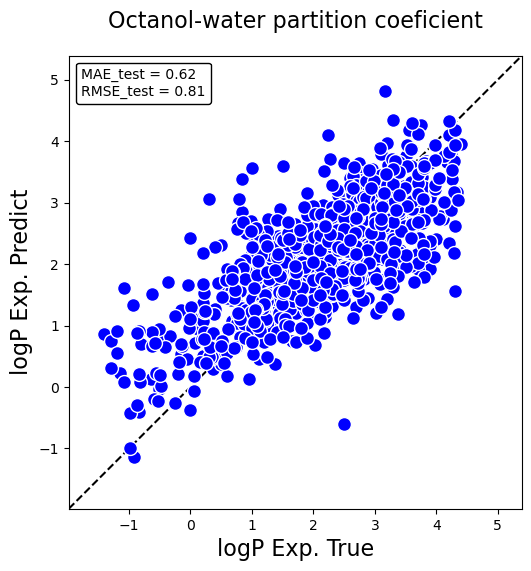

In [15]:
plot_parity(y_test_un, Exp_predict)

<div class="alert alert-block alert-info">
    
## Get the optimal hyperparameter?

Use *GridSearchCV* from scikit learn
    
</div>

In [16]:
params = {'activation': ['relu', 'tanh', 'logistic', 'identity'],
          'hidden_layer_sizes': list(itertools.permutations([50,100,150],2)) ,
          'solver': ['adam', 'lbfgs'],
          'learning_rate' : ['constant', 'adaptive', 'invscaling']
         }

ANNmodel = GridSearchCV(MLPRegressor(random_state=1000), param_grid=params, n_jobs=-1, cv=5, verbose=5)
ANNmodel.fit(X_train,Y_train)

print('Train R^2 Score : %.3f'%ANNmodel.best_estimator_.score(X_train, Y_train))
print('Test R^2 Score : %.3f'%ANNmodel.best_estimator_.score(X_test, Y_test))
print('Best R^2 Score Through Grid Search : %.3f'%ANNmodel.best_score_)
print('Best Parameters : ',ANNmodel.best_params_)

<div class="alert alert-block alert-info">
    
## How many training points do you need to get the errors as low as possible?

This is an example of a **different trained ML model** that shows that it only really needs just over 12,000 training points to train the machine learning model.
    
    
</div>

![learning curve](./learningcurve_morgan.png)

<div class="alert alert-block alert-info">
    
## Step 6: Deploy new data
Repeat the same as above. Read in data, calculate descriptors. deploy already trained model, and use your new data in the same way you used the "test data" previously.
    
    
</div>

** There's an excellent guide on the do's and don'ts of machine learning by Michael Lones that I feel people should definitley check out if you want to avoid some of the common pitfalls in machine learning. Click on the link below to download the pdf from the arXive pre-print server.

[How to avoid machine learning pitfalls:a guide for academic researchers, by Michael A. Lones](https://arxiv.org/pdf/2108.02497.pdf)